# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [3]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [9]:
n_models = 1
patience = 2
max_epochs = 200

ensemble_size = 1
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [5]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [6]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

## Determine LR

In [ ]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [7]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 1
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.773334449183602e-05
2 New best found: 3.4849788328187625e-05
3 New best found: 3.415115871267092e-05
5 New best found: 3.34806239514064e-05
6 New best found: 3.292612485634605e-05
7 New best found: 3.269952337678549e-05
11 New best found: 3.244926590719741e-05
13 New best found: 3.22232636377091e-05
15 New best found: 3.2148044001414286e-05
26 New best found: 3.212749541611544e-05
27 New best found: 3.186548173724508e-05
54 New best found: 3.1795173614550385e-05
56 New best found: 3.1790881782225225e-05
59 New best found: 3.17689814048416e-05
60 New best found: 3.174370493082643e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=4.342114733391104e-05
Early stopping after 137 epochs
Score is: {'loss': 3.174370493082643e-05, 'wAUC': 0.06327759658080945, 'AUC': 0.09850331526798739, 'AMS': 3.6935921066566584, 'cut': 0.9780678153038025}


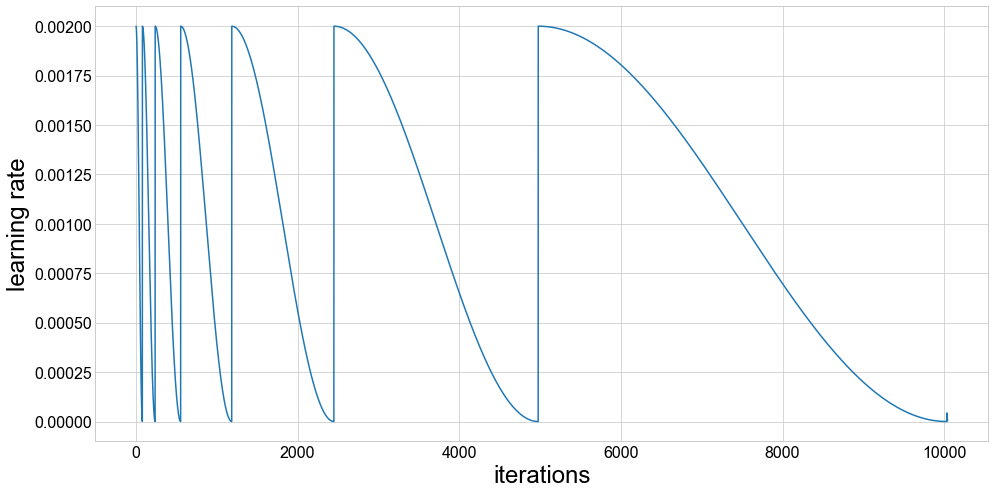

Fold took 53.283s


______________________________________
Training finished
Cross-validation took 53.381s 


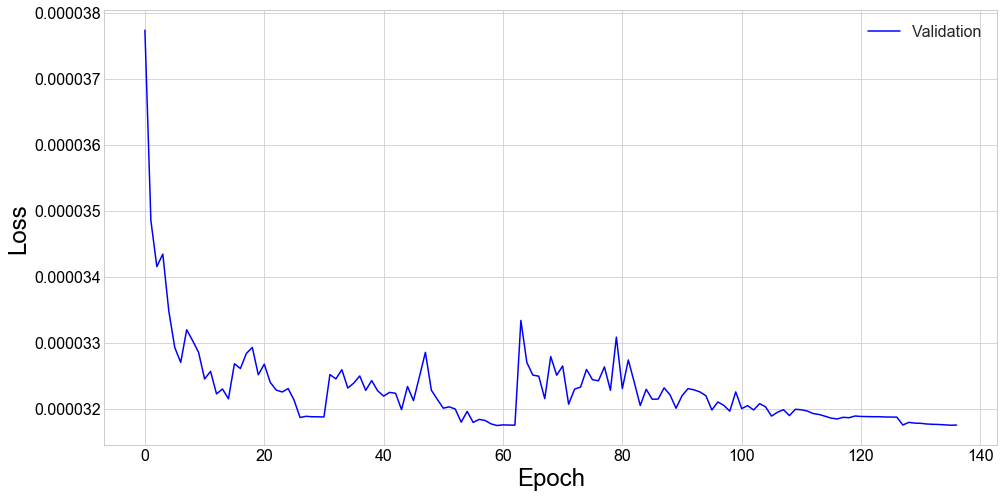

Mean loss = 3.174370493082643e-05 +- 0.0
Mean wAUC = 0.06327759658080945 +- 0.0
Mean AUC = 0.09850331526798739 +- 0.0
Mean AMS = 3.6935921066566584 +- 0.0
Mean cut = 0.9780678153038025 +- 0.0
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [11]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [12]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 0 with loss = 3.174370493082643e-05


## Response on validation data

In [13]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [14]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 2.2458525400725192e-05s per sample

Predicting fold 2 out of 10
Prediction took 9.061529400059953e-06s per sample

Predicting fold 3 out of 10
Prediction took 8.988220799074043e-06s per sample

Predicting fold 4 out of 10
Prediction took 9.96510139957536e-06s per sample

Predicting fold 5 out of 10
Prediction took 8.841611200477928e-06s per sample

Predicting fold 6 out of 10
Prediction took 8.961029999773019e-06s per sample

Predicting fold 7 out of 10
Prediction took 9.10847439954523e-06s per sample

Predicting fold 8 out of 10
Prediction took 9.851453200099059e-06s per sample

Predicting fold 9 out of 10
Prediction took 9.09760560025461e-06s per sample

Predicting fold 10 out of 10
Prediction took 9.387049199722242e-06s per sample



In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.902071017313905, weighted 0.9352429431566546


In [16]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.844946580702278, 0.96542305)

In [17]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=3.9+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9572032182477415, corresponds to calc_ams of 3.809482917944964
CPU times: user 3.46 s, sys: 4.39 s, total: 7.85 s
Wall time: 1min 28s


(3.9, 0.96, 0.9572032182477415)

In [40]:
import dask.dataframe as dd
from dask.multiprocessing import get

In [51]:
val_df = convert_to_df(val_fy.source); val_df.head()

50000 candidates loaded


,gen_target,gen_weight,pred_class
0,0,1.248925,0.012886
1,0,2.571630,0.033639
2,1,0.001502,0.968827
3,0,0.064061,0.133173
4,0,4.610951,0.002689


In [41]:
val_df = dd.from_pandas(convert_to_df(val_fy.source), npartitions=8); val_df.head()

50000 candidates loaded


,gen_target,gen_weight,pred_class
0,0,1.248925,0.012886
1,0,2.571630,0.033639
2,1,0.001502,0.968827
3,0,0.064061,0.133173
4,0,4.610951,0.002689


In [64]:
%%time
w_factor = 250000/50000
val_df['ams'] = val_df.apply(lambda row: calc_ams(w_factor*np.sum(val_df.loc[(val_df.pred_class >= row.pred_class) &
                                                                     (val_df.gen_target == 1), 
                                                                    'gen_weight']),
                                                  w_factor*np.sum(val_df.loc[(val_df.pred_class >= row.pred_class) &
                                                                    (val_df.gen_target == 0),
                                                                    'gen_weight']),
                                                  br=10), axis=1)

CPU times: user 1min 24s, sys: 262 ms, total: 1min 24s
Wall time: 1min 24s


In [65]:
np.max(val_df['ams'])

3.844946580702278

In [163]:
len(val_df[val_df.ams >= np.percentile(val_df.ams, 9)])

500

In [166]:
0.01*len(val_df)

500.0

In [188]:
cuts = val_df.sort_values(by='ams', ascending=False)['pred_class'].values[0:int(0.02*len(val_df))]

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


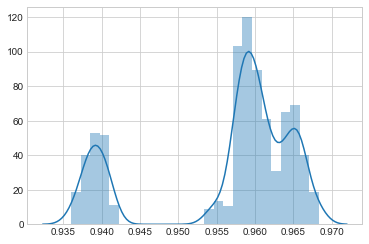

In [189]:
sns.distplot(cuts)

In [184]:
import statsmodels.api as sm

In [185]:
kde = sm.nonparametric.KDEUnivariate(cuts.astype('float64'))
kde.fit()

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [186]:
points = np.array([(x, kde.evaluate(x)) for x in np.linspace(cuts.min(), cuts.max(), 1000)])

In [187]:
points[np.argmax(points[:,1])]

array([ 0.96403936, 45.41033809])

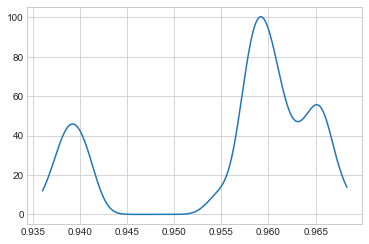

In [181]:
plt.plot(points[:,0], points[:,1])

In [99]:
np.min(cuts)

0.9585679

(0.9, 1)

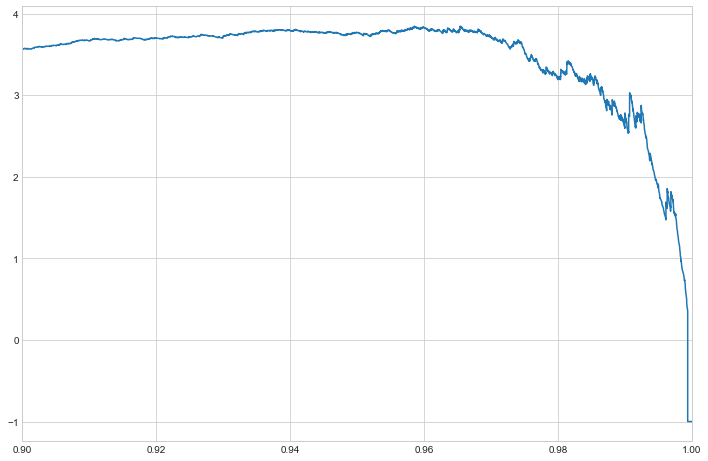

In [70]:
plt.figure(figsize=(12,8))
val_df.sort_values(by='pred_class', inplace=True)
plt.plot(val_df.pred_class, val_df.ams)
plt.xlim(0.9,1)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


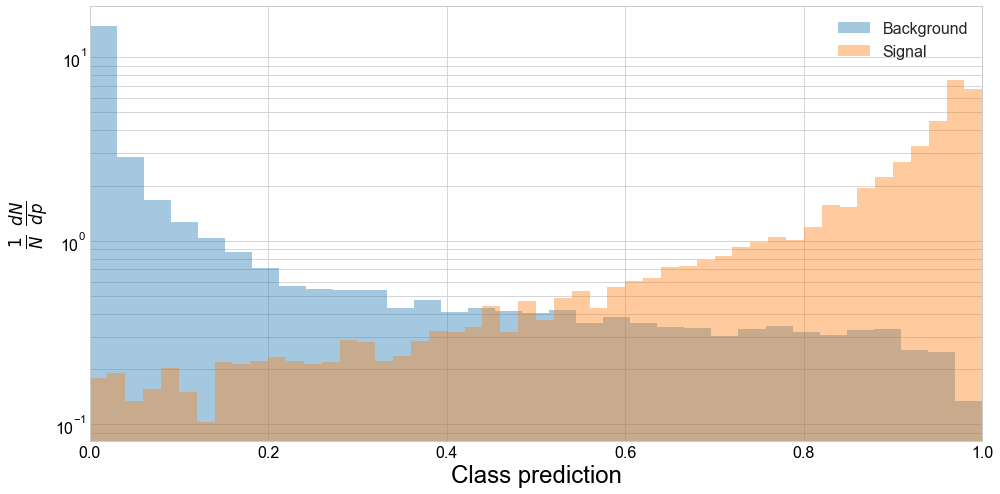

In [26]:
get_class_pred_plot([val_df[val_df.gen_target == 0], val_df[val_df.gen_target == 1]], weight_name='gen_weight')

In [ ]:
def plot_ams(in_data):
    x = 

# Test scoring

In [18]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [19]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 1.1280198290875309e-05s per sample

Predicting fold 2 out of 10
Prediction took 9.055152163570959e-06s per sample

Predicting fold 3 out of 10
Prediction took 9.253342472683553e-06s per sample

Predicting fold 4 out of 10
Prediction took 1.0082071836487475e-05s per sample

Predicting fold 5 out of 10
Prediction took 9.435954672649545e-06s per sample

Predicting fold 6 out of 10
Prediction took 9.192369018141603e-06s per sample

Predicting fold 7 out of 10
Prediction took 9.180221690886274e-06s per sample

Predicting fold 8 out of 10
Prediction took 9.055096890899057e-06s per sample

Predicting fold 9 out of 10
Prediction took 8.947891436400824e-06s per sample

Predicting fold 10 out of 10
Prediction took 8.978247963717546e-06s per sample

CPU times: user 6.44 s, sys: 1.2 s, total: 7.64 s
Wall time: 5.21 s


In [20]:
score_test_data(test_fy.source, 0.9572032182477415)

Public:Private AMS: 3.6393199467681807 : 3.6707866269435945


(3.6393199467681807, 3.6707866269435945)

In [137]:
score_test_data(test_fy.source, 0.96542305)

Public:Private AMS: 3.588393653136325 : 3.632910803207415


(3.588393653136325, 3.632910803207415)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)